# Содержание

- [Логистическая регрессия](#logreg-section)
- [Метрики](#metrics-section)
- [Мультиклассовая классификация](#multiclass-section)
- [Деревья решений](#desicion-trees-section)
- [Введение в ансамбли](#ensembles-intr-section)

# Классификация
Классификация — это задача, в которой мы пытаемся предсказать класс объекта на основе признаков в наборе данных. То есть задача сводится к предсказанию целевого признака, который является категориальным.

<a id="logreg-section"></a>
## Логистическая регрессия

Логистическая регрессия — одна из простейших моделей для решения задачи классификации, в ее основе лежит логистическая функция $\sigma(z)$ (сигмоид):
$$ \sigma(z) = \frac{1}{1 + e^{-z}} $$
Для оценки вероятности используется модель линейной регрессии и сигмоид:
$$ z = \omega_0 + \sum_{j=1}^m \omega_j x_j $$ 
$$ \hat{P} = \sigma(z) = \frac{1}{1 + e^{-\bar{\omega}\bar{x}}} $$ 
$$ \hat{y} = I|\hat{P}| =
  \begin{cases}
  1, \hat{P} > 0.5 \\
  0, \hat{P} \leq 0.5
  \end{cases}
$$

### Функция логистических потерь
$$L(w) = \text { logloss } =-\sum_{i}^{n} (y_{i} log (\hat{P_{i}}) + (1-y_{i}) log (1-\hat{P_{i}})) \rightarrow min_{w}$$

Найдем минимум функции с помощью метода градиантного спуска:
$$ \omega^{(k+1)}=\omega^{(k)}-\eta \nabla L\left(\omega^{(k)}\right) $$

На практике обычно используется стохастический градиентный спуск (SGD). Кроме того, чтобы избежать переобучения применяется регуляризация.
### L1-регуляризация
$$ L(w)=C \cdot \log \operatorname{loss}+\sum_{j=1}^{m}\left|w_{j}\right| \rightarrow \min_{w} $$
### L2-регуляризация
$$ L(w)=\mathrm{C} \cdot \log \operatorname{loss}+\sum_{j=1}^{m}\left(w_{j}\right)^{2} \rightarrow \min _{w} $$

### Инициализация данных

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных

diabetes_data = pd.read_csv('data/diabetes_cleaned.csv')
X = diabetes_data[['Glucose', 'BMI']]
y = diabetes_data['Outcome']

### Обучение и прогнозирование с помощью LogisticRegression

In [2]:
from sklearn import linear_model

#Создаём объект класса LogisticRegression
log_reg_2d = linear_model.LogisticRegression(random_state=42)
#Обучаем модель, минимизируя logloss
log_reg_2d.fit(X.values, y.values) # добавил .values, чтобы не показывалось предупреждение
#Выводим результирующие коэффициенты
print('w0: {}'.format(log_reg_2d.intercept_)) #свободный член w0
print('w1, w2: {}'.format(log_reg_2d.coef_)) #остальные параметры модели w1, w2, ..., wm

w0: [-8.24898965]
w1, w2: [[0.03779275 0.0875742 ]]


In [3]:
# Можно получить предсказание в виде распределения вероятностей

#Значения концентрации глюкозы и индекса массы тела для пациента
x_new = [[180, 51]]
#Делаем предсказание вероятностей:
y_new_proba_predict = log_reg_2d.predict_proba(x_new)
print('Predicted probabilities: {}'.format(np.round(y_new_proba_predict, 2)))

Predicted probabilities: [[0.05 0.95]]


In [4]:
# Можно получить предсказание в виде номера класса

#Значения концентрации глюкозы и индекса массы тела для пациента
x_new = [[180, 51]]
#Делаем предсказание класса:
y_new_predict = log_reg_2d.predict(x_new)
print('Predicted class: {}'.format(y_new_predict))

Predicted class: [1]


<a id="metrics-section"></a>
## Метрики

Матрица ошибок (confusion matrix) показывает все возможные исходы совпадения и несовпадения предсказания модели с действительностью. Используется для расчёта других метрик.
![confusion matrix](data/confusion_matrix.png "Confusion matrix")

In [5]:
from sklearn import metrics

y_pred = log_reg_2d.predict(diabetes_data[['Glucose', 'BMI']].values)
confusion_matrix = metrics.confusion_matrix(y, y_pred)
confusion_matrix

array([[437,  56],
       [124, 140]], dtype=int64)

### Accuracy
Accuracy (достоверность) — доля правильных ответов модели среди всех ответов. Правильные ответы — это истинно положительные (True Positive) и истинно отрицательные ответы (True Negative):
$$accuracy = \frac{TP + TN}{TP + TN + FN + FP}$$
#### Преимущества
* Очень легко интерпретировать.
* Автоматически можно посчитать процент ошибок модели как $1-accuracy$.
#### Недостатки
* Плохо показывает себя на сильно несбалансированных классах.

In [6]:
accuracy = metrics.accuracy_score(y, y_pred)
accuracy

0.76221928665786

### Precision
Precision (точность), или PPV (Positive Predictive Value) — это доля объектов, которые действительно являются положительными, по отношению ко всем объектам, названным моделью положительными:
$$ precision = \frac{TP}{TP+FP} $$
Отражает способность модели отделять класс 1 от класса 0. Используется в задачах, где важно минимальное количество ложных срабатываний модели.
#### Преимущества
* Можно использовать на несбалансированных выборках.
#### Недостатки
* Вычисляется только для положительного класса — класса 1. Для класса 0 показатель необходимо вычислять отдельно.
* Не даёт представления о том, как много объектов положительного класса из общей совокупности нашёл алгоритм.

In [7]:
precision = metrics.precision_score(y, y_pred)
precision

0.7142857142857143

### Recall
Recall (полнота), или TPR (True Positive Rate) — это доля объектов, названных классификатором положительными, по отношению ко всем объектам положительного класса:
$$ recall = \frac{TP}{TP + FN} $$
Отражает способность модели находить класс 1. Используется в задачах, где важно охватить как можно больше объектов положительного класса (1).
#### Преимущества
* Можно использовать на несбалансированных выборках.
#### Недостатки
* Вычисляется только для положительного класса — класса 1. Для класса 0 показатель необходимо вычислять отдельно.
* Не даёт представления о том, насколько точно модель находит объекты положительного класса (как много ложных срабатываний).

In [8]:
recall = metrics.recall_score(y, y_pred)
recall

0.5303030303030303

### F-мера
$F_{\beta}$ (F-мера) — это взвешенное среднее гармоническое между precision и recall:
$$ F_{\beta} = (1+\beta^{2})\frac{precision \cdot recall}{(\beta^{2} precision) + recall}, $$
где $\beta$ — это вес precision в метрике: чем больше $\beta$, тем больше вклад. \
Если $\beta = 0$ получаем $F_1$-меру:
$$ F_{1} = 2\frac{precision \cdot recall}{precision + recall} $$
Нет бизнес-интерпретации. Используется в задачах, где необходимо балансировать между $precision$ и $recall$.
#### Преимущества
* Дает обобщенное представление о точности и полноте.
* Максимум достигается, когда максимальны обе метрики, минимум — когда хотя бы одна из метрик равна 0.
* При желании можно использовать обобщённый вариант — $F_{\beta}$, чтобы управлять вкладом precision в общую метрику.
#### Недостатки
* Отсутствие интерпретации не даёт интуитивного понимания человеку, не знакомому с этой метрикой.

In [9]:
f1 = metrics.f1_score(y, y_pred)
f1

0.608695652173913

Можно одновременно рассчитать все метрики с помощью функции  classification_report().

In [10]:
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       493
           1       0.71      0.53      0.61       264

    accuracy                           0.76       757
   macro avg       0.75      0.71      0.72       757
weighted avg       0.76      0.76      0.75       757



Здесь *support* — это количество объектов каждого из классов, *macro avg* — это среднее значение метрики между классами 1 и 0, *weighted avg* — это средневзвешенное значение метрики между классами 1 и 0, которое рассчитывается по формуле:
$$ score_{weighted-avg} = \frac{n_{class_0}}{n} score_{class_0} + \frac{n_{class_1}}{n} score_{class_1} $$

Попробуем изменить порог принятия решений, чтобы улучшить метрики.

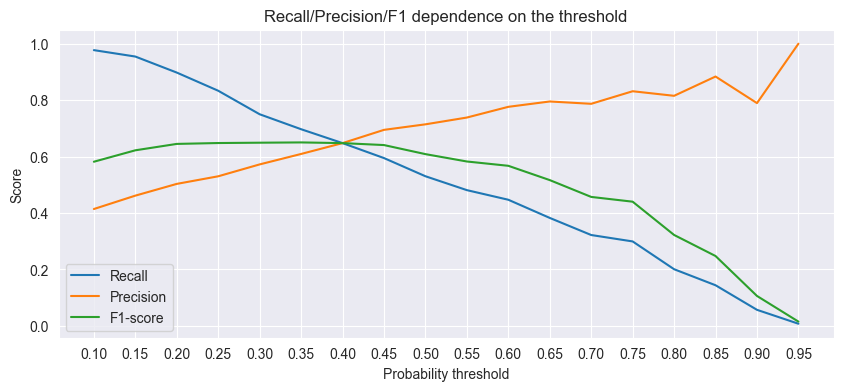

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

#Считаем вероятности наличия диабета для каждого из пациентов
#Нас интересует только вероятность класса (второй столбец)
y_proba_pred = log_reg_2d.predict_proba(diabetes_data[['Glucose', 'BMI']].values)[:, 1]
#Для удобства завернём numpy-массив в Pandas Series
y_proba_pred = pd.Series(y_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold, относим к классу 1
    #В противном случае — к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y, y_pred))
    precision_scores.append(metrics.precision_score(y, y_pred))
    f1_scores.append(metrics.f1_score(y, y_pred))

#Визуализируем метрики при различных threshold
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
 
#Даём графику название и подписываем оси
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend()

Заметим, что при пороге 0,4 $F_1$-метрика имеет максимальное значение (на отрезке от 0,2 до 0,4), а также совпадают значения всех трех метрик. Выберем 0,4 в качестве нового порога, пересчитаем прогноз и метрики.

In [12]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.4
#Пациентов, для которых вероятность наличия диабета > 0.4, относим к классу 1
#В противном случае — к классу 0
y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y, y_pred_opt))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       493
           1       0.65      0.65      0.65       264

    accuracy                           0.75       757
   macro avg       0.73      0.73      0.73       757
weighted avg       0.75      0.75      0.75       757



<a id="multiclass-section"></a>
## Мультиклассовая классификация

Используется подход "один против всех" (one-vs-over). Идея очень простая — если у нас есть $k$ различных классов ($k>2$), давайте обучим $k$ классификаторов, каждый из которых будет предсказывать вероятности принадлежности каждого объекта к определённому классу. Модель логистической регрессии легко обобщается на случай мультиклассовой классификации. Пусть мы построили несколько разделяющих гиперплоскостей с различными наборами параметров $k$, где $k$ — номер классификатора. То есть имеем $k$ разделяющих плоскостей:
$$ z_{k}=w_{0 k}+\sum_{j=1}^{m} w_{j k} x_{j}=w_{k} \cdot x $$

Чтобы преобразовать результат каждой из построенных моделей в вероятности в логистической регрессии, используется функция *softmax* — многомерный аналог сигмоиды:
$$ \hat{P}_{k}=\operatorname{softmax}\left(z_{k}\right)=\frac{\exp \left(\hat{y}_{k}\right)}{\sum_{k=1}^{K} \exp \left(\hat{y}_{j k}\right)} $$

In [13]:
penguins_data = sns.load_dataset('penguins')
penguins_data = penguins_data.dropna()
X = penguins_data.drop('species', axis=1)
y = penguins_data['species']
X_dummies = pd.get_dummies(X)

#Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(
    multi_class='multinomial', #мультиклассовая классификация
    max_iter=1000, #количество итераций, выделенных на сходимость
    random_state=42 #генерация случайных чисел
)
 
#Обучаем модель 
log_reg.fit(X_dummies, y)
#Делаем предсказание вероятностей
y_pred_proba = np.round(log_reg.predict_proba(X_dummies), 2)
#Делаем предсказание класса
y_pred = log_reg.predict(X_dummies)
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00       146
   Chinstrap       1.00      1.00      1.00        68
      Gentoo       1.00      1.00      1.00       119

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333



C:\Users\maxim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Достоинства логистической регресии
* Простой, интерпретируемый, но в то же время эффективный алгоритм. Благодаря этому он очень популярен в мире машинного обучения.
* Поиск параметров линейный или квадратичный (в зависимости от метода оптимизации), то есть ресурсозатратность алгоритма очень низкая.
* Не требует подбора внешних параметров (гиперпараметров), так как практически не зависит от них.

### Недостатки логистической регресии
* Алгоритм работает хорошо, только когда классы линейно разделимы, что в реальных задачах бывает очень редко. Поэтому обычно данная модель используется в качестве *baseline*.

<a id="desicion-trees-section"></a>
## Деревья решений

Дерево решений предсказывает значение целевой переменной с помощью применения последовательности простых решающих правил. Этот процесс в некотором смысле согласуется с естественным для человека процессом принятия решений. \
Формально структура дерева решений — это **связный ациклический граф**. \
Максимально возможная длина от корня до самых дальних листьев (не включая корневую) называется **максимальной глубиной дерева** (max depth). \
Логический критерий, который находится в каждой вершине, называется **предикатом**, или **решающим правилом**. Формально это записывается следующим образом:
$$ B_{v}(x, t)=I\left[x_{j} \leq t\right] $$
Предикат $B_{v}$ ($v$ — номер вершины) равен 1, если признак $x_{j}$ меньше или равен значению $t$ и 0 в противном случае.

### Построение дерева по алгоритму CART (Classification and Regression Tree)
Этот алгоритм позволяет строить бинарные деревья решений и предназначен для решения задач классификации и регрессии. В основе алгоритма рекурсивный подход. Разберем рекурсивный процесс:
1. Создаем вершину.
2. Проверяем критерий останова. Таких критерив может быть несколько: а) все объекты, которые попали в вершину, относятся к одному классу; б) достигнута максимальная глубина дерева; в) число наблюдений, которые попали в вершину, меньше заданного.
    * *Если условие остановки выполняется*, проверить, какой класс преобладает в вершине. Текущая вершина становится листом с меткой преобладающего класса.
    * *Если условие остановки не выполняется*, среди всех возможных предикатов $ B_{v}(x, t)=I\left[x_{j} \leq t\right] $ выбрать тоткоторый обеспечивает разбиение выборки **наилучшим образом**. То есть нужно найти такой признак $x_j$ и пороговое значение $t$, при которых достигается максимум некой информативности. Затем набор данных разделяется на два и для каждого из них повторяется рекурсивный процесс.

Пусть в вершину $B_v$ попало множество $X_v$ и $y_v$ объектов из обучающей выборки размером $n_v$, где $n$ — количество наблюдений, а $v$ — номер вершины.
Разбиение выбирается так, чтобы минимизировать функцию $L(j, t)$:
$$ L(j,t) \rightarrow min_{j,t}, $$
где $j$ — номер признака, а $t$ — пороговое значение.
Параметры $j$ и $t$ мы выбираем простым перебором всех возможных значений. После того как параметры были выбраны, множества $X_v$ объектов из обучающей выборки и ответов к ним $y_v$ разбиваются на два: $Q_{left} = (X_{left}, \ y_{left})$ и $Q_{right} = (X_{right}, \ y_{right})$, для которых условие $\left [ x_{j} \leq t \right ]$ выполняется и не выполняется соответственно. Каждая из полученных выборок будет иметь свои размеры, назовём их $n_v^{left}$ и $n_v^{right}$. Тогда функция ошибки, численно выражающая неопределённость, будет состоять из двух слагаемых (неопределённость для левой и правой вершин) и определяться следующим образом:
$$ L(j, t)=\frac{n_{v}^{l e f t}}{n_{v}} H\left(Q_{l e f t}\right)+\frac{n_{v}^{r i g h t}}{n_{v}} H\left(Q_{r i g h t}\right), $$
где $H(Q)$ — это функция, которая называется критерием информативности. Её значение уменьшается с уменьшением разброса ответов на выборке.

#### Функции информативности:
1. **Энтропия Шеннона**
$$ H(Q) = -\sum_{i=1}^{k} \ P_{i} \ log_{2} \ P_{i}, $$
где $k$ — количество классов, $P_i$ — вероятность принадлежности объекта к $i$-му классу. Чем выше энтропия, тем менее упорядочена система, и наоборот.

2. **Критерий Джинни**
$$ H(Q) = \sum_{i=1}^{k} \ P_{i} \ (1-P_{i}), $$
где $k$ — количество классов, $P_i$ — вероятность принадлежности объекта к $i$-му классу. Минимум функции достигается только в том случае, когда все объекты в выборке относятся к одному классу.

In [14]:
X = diabetes_data[['Glucose', 'BMI']]
y = diabetes_data['Outcome']


In [15]:
from sklearn import tree #модели деревьев решения

#Создаём объект класса DecisionTreeClassifier
dt_clf_2d = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    max_depth=3, #максимальная глубина
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART
dt_clf_2d.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

Параметры класса DecisionTreeClassifier:
* criterion — критерий информативности ('gini' — критерий Джини и 'entropy' — энтропия Шеннона).
* max_depth — максимальная глубина дерева (по умолчанию — None, глубина дерева не ограничена).
* max_features — максимальное число признаков, по которым ищется лучшее разбиение в дереве (по умолчанию — None, то есть обучение производится на всех признаках). Нужно потому, что при большом количестве признаков будет «дорого» искать лучшее (по критерию типа прироста информации) разбиение среди всех признаков.
* min_samples_leaf — минимальное число объектов в листе (по умолчанию — 1). У этого параметра есть понятная интерпретация: если он равен 5, то дерево будет порождать только те решающие правила, которые верны как минимум для пяти объектов.
* random_state — число, отвечающее за генерацию случайных чисел.

[Text(0.5, 0.875, 'Glucose <= 127.5\nentropy = 0.933\nsamples = 757\nvalue = [493, 264]\nclass = 0 - Not diabetic'),
 Text(0.25, 0.625, 'BMI <= 26.45\nentropy = 0.712\nsamples = 477\nvalue = [384, 93]\nclass = 0 - Not diabetic'),
 Text(0.125, 0.375, 'BMI <= 22.95\nentropy = 0.069\nsamples = 122\nvalue = [121, 1]\nclass = 0 - Not diabetic'),
 Text(0.0625, 0.125, 'entropy = 0.162\nsamples = 42\nvalue = [41, 1]\nclass = 0 - Not diabetic'),
 Text(0.1875, 0.125, 'entropy = 0.0\nsamples = 80\nvalue = [80, 0]\nclass = 0 - Not diabetic'),
 Text(0.375, 0.375, 'Glucose <= 99.5\nentropy = 0.825\nsamples = 355\nvalue = [263, 92]\nclass = 0 - Not diabetic'),
 Text(0.3125, 0.125, 'entropy = 0.493\nsamples = 130\nvalue = [116, 14]\nclass = 0 - Not diabetic'),
 Text(0.4375, 0.125, 'entropy = 0.931\nsamples = 225\nvalue = [147, 78]\nclass = 0 - Not diabetic'),
 Text(0.75, 0.625, 'BMI <= 29.95\nentropy = 0.964\nsamples = 280\nvalue = [109, 171]\nclass = 1 - Diabetic'),
 Text(0.625, 0.375, 'Glucose <= 14

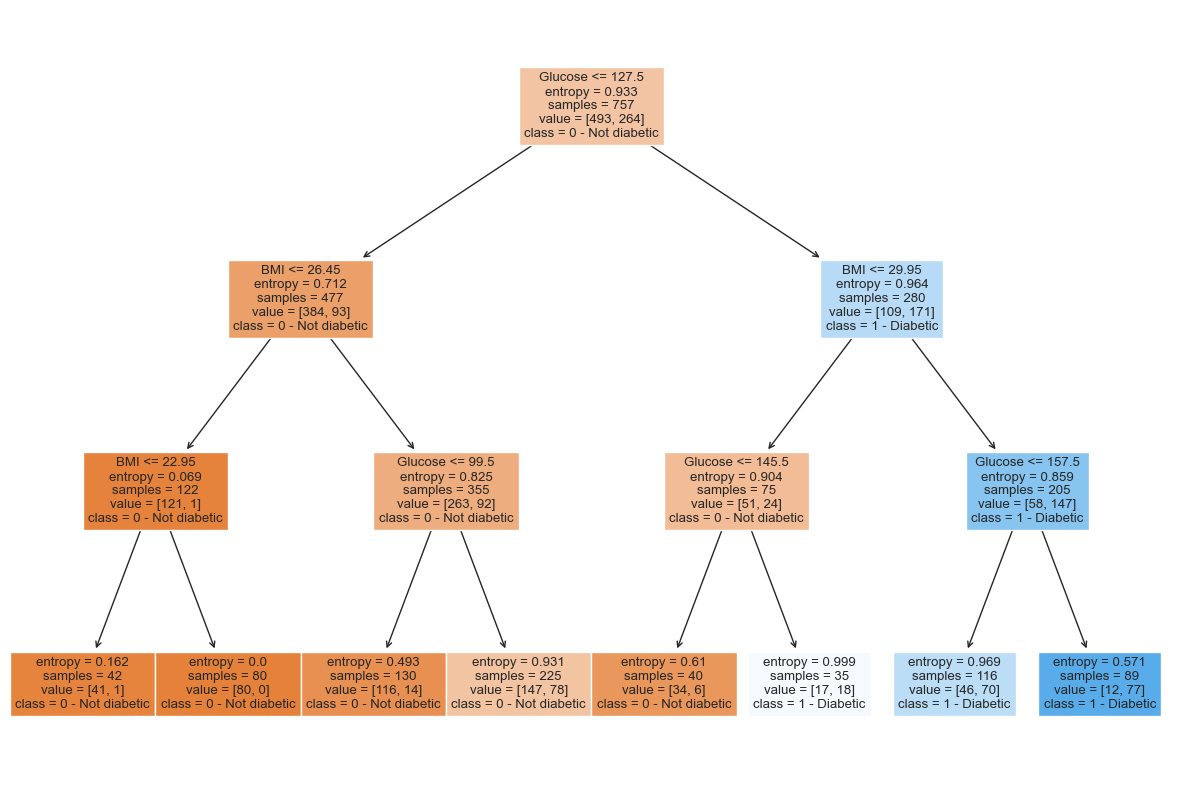

In [16]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
#Строим граф дерева решений
tree.plot_tree(
    dt_clf_2d, #объект обученного дерева
    feature_names=X.columns, #наименования факторов
    class_names=["0 - Not diabetic", "1 - Diabetic"], #имена классов
    filled=True, #расцветка графа
)

In [17]:
#Значения концентрации глюкозы и индекса массы тела для пациента
x_new = [[180, 51]]
#Делаем предсказание класса:
y_new_predict = dt_clf_2d.predict(x_new)
print('Predicted class: {}'.format(y_new_predict))

Predicted class: [1]


C:\Users\maxim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [18]:
#Значения концентрации глюкозы и индекса массы тела для пациента
x_new = [[180, 51]]
#Делаем предсказание вероятностей:
y_new_proba_predict = dt_clf_2d.predict_proba(x_new)
print('Predicted probabilities: {}'.format(np.round(y_new_proba_predict, 3)))

Predicted probabilities: [[0.135 0.865]]


C:\Users\maxim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


### Регуляризация
Для регуляризации деревьев можно ограничивать их максимальную глубину (max_depth) и минимальное число объектов в листе (min_samples_leaf).

### Важность признаков
Дерево решений позволяет определить важность признаков.

Text(0, 0.5, 'Importances')

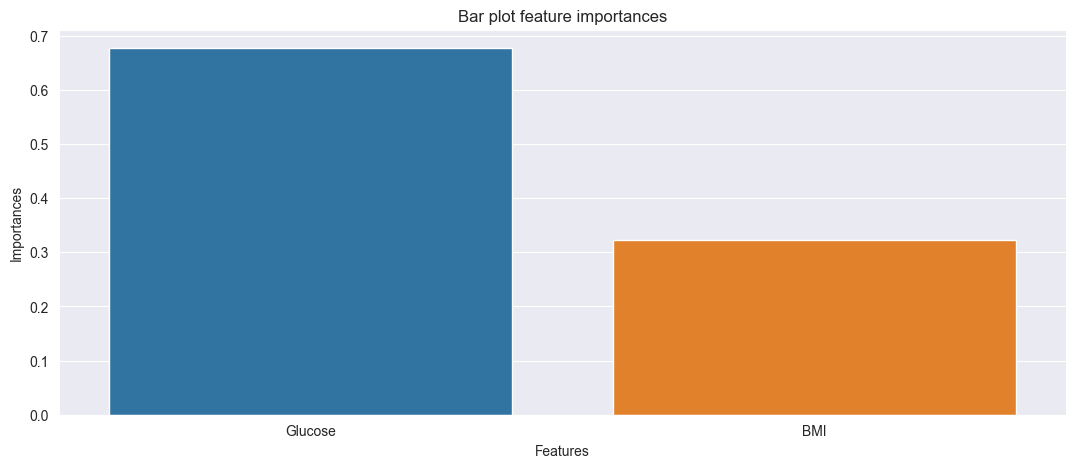

In [19]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X.columns #признаки
feature_importances = dt_clf_2d.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax)
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances')


>Часто «древесные» модели используются в качестве методов для отбора наиболее важных признаков. Это важно, когда в вашем наборе данных большое количество признаков, из-за которых обучение более сложных моделей может стать очень длительным. 

>Кроме того, значимость признаков можно использовать в рамках анализа бизнес-процессов. Значимость позволяет понять, на какие признаки стоит обратить наибольшее внимание, чтобы повысить, например, точность их измерения.

### Преимущества и недостатки деревьев решений
#### Преимущества
* Дерево решений не требует нормализации/стандартизации данных.
* Наличие пропусков не оказывает существенного влияния на построение дерева.
* За счёт своей простоты модель деревьев решений интуитивно понятна и легко объяснима даже людям, не разбирающимся в методе.
* Приятный побочный эффект построения дерева решений — получение значимости признаков. Однако коэффициенты значимости целиком и полностью зависят от сложности дерева.
#### Недостатки
* В силу дискретной топологической структуры дерево не дифференцируется по параметрам: стандартные алгоритмы поиска параметров, такие как градиентный спуск, не работают. Приходится использовать полный перебор.
* Так как метод является жадным, он долго обучается из-за полного перебора. Требует затрат больших вычислительных мощностей (по сравнению с другими алгоритмами). Особенно это ощутимо при большом количестве признаков на глубоких деревьях.
* Очень сильная склонность к переобучению. Необходим подбор внешних параметров: max_depth, min_sample_leaf и другие (о том, как организовать этот подбор, мы поговорим в отдельном модуле).
* Небольшое изменение в данных может заметно повлиять на структуру дерева.
* При работе с непрерывными числовыми признаками дерево делит их на категории и теряет информацию. Лучше всего дерево работает, если перевести числовые признаки в категориальные.

<a id="ensembles-intr-section"></a>
## Введение в ансамбли

Ансамблевые модели или просто ансамбли (ensembles) — это метод машинного обучения, где несколько простых моделей (часто называемых «слабыми учениками») обучаются для решения одной и той же задачи и объединяются для получения лучших результатов.
___
Необходимость использования ансамблей может возникнуть тогда, когда вы уже нашли хорошую модель и никак больше не можете повысить её качество. В этом случае можно перейти к более продвинутому методу: использовать не одну модель (пусть и очень хорошую), а ансамбли моделей.
___
Существует **три проверенных способа построения ансамблей**:
1. **Бэггинг** — параллельно обучаем множество одинаковых моделей, а для предсказания берём среднее по предсказаниям каждой из моделей.
2. **Бустинг** — последовательно обучаем множество одинаковых моделей, где каждая новая модель концентрируется на тех примерах, где предыдущая допустила ошибку.
3. **Стекинг** — параллельно обучаем множество разных моделей, отправляем их результаты в финальную модель, и уже она принимает решение.

### Бэггинг
**Бэггинг (bagging)** — это алгоритм построения ансамбля путём параллельного обучения множества независимых друг от друга моделей. \
В основе алгоритма лежит статистический метод, который называется бутстрэпом (bootstrap). Идея бутстрэпа заключается в генерации $k$ выборок размера $n$ (бутстрэп-выборок) из исходного набора данных размера $m$ путём случайного выбора элементов с повторениями в каждом из наблюдений.

>Такие бутстрэп-выборки часто используются для оценки различных статистических показателей (например, разброса или доверительного интервала). Если вычислять статистические оценки на нескольких независимых выборках, то мы можем оценить их разброс. Поиск большого количества независимых выборок сложен в силу того, что для этого требуется слишком много данных. Поэтому мы используем бутстрэп, чтобы создать несколько выборок.

Обучим $k$ одинаковых моделей на каждой из сгенерированных выборок, сделаем предсказания, а затем усредним их. Так мы получим бэггинг.

>В случае классификации «усреднение» означает мажоритарное голосование (принцип большинства голосов). То есть объект относится к тому классу, за который проголосовало большинство алгоритмов.

Важно отметить, что в бэггинге в голосовании принимает участие модель одного вида. Эта модель называется **базовой моделью** (base model). Нельзя обучить на половине сгенерированных наборов данных логистические регрессии, а на второй половине — деревья решений.

Свойства бэггинг-ансамблей:
* Смещение (bias) бэггинг-ансамбля не больше смещения одного алгоритма из этого ансамбля.
* Разброс (variance) бэггинг-ансамбля в $k$ раз меньше, чем разброс одного алгоритма из ансамбля, где $k$ — количество алгоритмов в ансамбле.

### Случайный лес (Random Forest)
Это самая распространённая реализация бэггинга, основанная на использовании в качестве базовой модели дерева решений. 

Помимо бутстрэпа, в случайном лесе используется метод случайных подпространств. Суть этого метода заключается в том, что каждая модель обучается не на всех признаках, а только на части из них. Такой подход позволяет уменьшить коррелированность между ответами деревьев и сделать их независимыми друг от друга.

#### АЛГОРИТМ ПОСТРОЕНИЯ СЛУЧАЙНОГО ЛЕСА ДЛЯ ЗАДАЧИ КЛАССИФИКАЦИИ
Пусть количество объектов в наборе данных равно $N$, а количество признаков — $M$. То есть размер набора данных — $(N, M)$. Количество деревьев в лесу равно $K$. Тогда для обучения случайного леса необходимо выполнить следующие шаги:
1. С помощью бутстрэпа создать K наборов данных размера $(N, M)$.
2. Для каждого сгенерированного набора данных применить метод случайных подпространств: выбрать $L < M$ случайных признаков и получить $K$ новых наборов данных размером $(N, L)$.
3. На каждом наборе данных обучить $K$ деревьев решений.

В библиотеке *sklearn* модель случайного леса для решения задачи классификации реализована в классе **RandomForestClassifier**. Вот его основные параметры:
* n_estimators — количество деревьев в лесу (число K из бэггинга; по умолчанию равно 100);
* criterion — критерий информативности разбиения для каждого из деревьев ('gini' — критерий Джини и 'entropy' — энтропия Шеннона; по умолчанию — 'gini');
* max_depth — максимальная глубина одного дерева (по умолчанию — None, то есть глубина дерева не ограничена);
* max_features — максимальное число признаков, которые будут использоваться каждым из деревьев (число L из метода случайных подпространств; по умолчанию — 'sqrt'; для обучения каждого из деревьев используется $\sqrt{m}$ признаков, где $m$ — число признаков в начальном наборе данных);
* min_samples_leaf — минимальное число объектов в листе (по умолчанию — 1);
* random_state — параметр, отвечающий за генерацию случайных чисел.

In [20]:
from sklearn import ensemble

#Создаём объект класса RandomForestClassifier
rf_clf_2d = ensemble.RandomForestClassifier(
    n_estimators=500, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=3, #максимальная глубина дерева
    max_features='sqrt', #число признаков из метода случайных подпространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_2d.fit(X, y)
 
#Делаем предсказание класса
y_pred = rf_clf_2d.predict(X)
#Выводим отчёт о метриках
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.88      0.84       493
           1       0.73      0.57      0.64       264

    accuracy                           0.78       757
   macro avg       0.76      0.73      0.74       757
weighted avg       0.77      0.78      0.77       757



Text(0, 0.5, 'Importances')

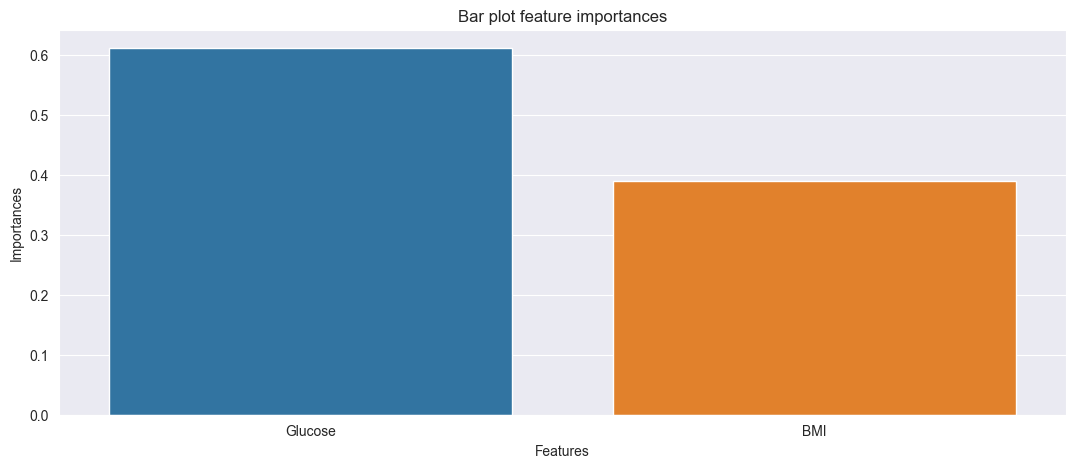

In [21]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X.columns #признаки
feature_importances = rf_clf_2d.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax)
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances')